<a href="https://colab.research.google.com/github/11PRIMUS/Early-Stage-Cancer-Prediction/blob/main/SKIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!unzip /content/skinC.zip

Archive:  /content/skinC.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024707.jpg  
  inflating: Skin cancer ISIC The I

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
import os
import shutil
import glob

In [ ]:
#count no of img 1-brain tumor and 0-healthy
ROOT_DIR="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
number_of_images={}

for dir in os.listdir(ROOT_DIR):
  number_of_images[dir]=len(os.listdir(os.path.join(ROOT_DIR,dir)) )

number_of_images.items()

dict_items([('actinic keratosis', 114), ('pigmented benign keratosis', 462), ('vascular lesion', 139), ('nevus', 357), ('seborrheic keratosis', 77), ('melanoma', 438), ('squamous cell carcinoma', 181), ('basal cell carcinoma', 376), ('dermatofibroma', 95)])

In [ ]:
def dataFolder(p, split=0.7):
    # Check if the target folder exists
    if not os.path.exists("./" + p):
        os.mkdir("./" + p)

        for dir in os.listdir(ROOT_DIR):
            # Create subdirectory in the new folder
            os.makedirs(os.path.join("./" + p, dir))

            # Select a random subset of images
            number_of_images_in_dir = number_of_images[dir]
            selected_images = np.random.choice(
                a=os.listdir(os.path.join(ROOT_DIR, dir)),
                size=(math.floor(split * number_of_images_in_dir)),
                replace=False
            )

            # Copy selected images to the new location and delete originals
            for img in selected_images:
                original_path = os.path.join(ROOT_DIR, dir, img) # Original path
                destination_dir = os.path.join("./" + p, dir)   # Destination folder

                # Check if it's a file before copying
                if os.path.isfile(original_path):
                    shutil.copy(original_path, destination_dir)     # Copy image
                    os.remove(original_path)                        # Remove original image
    else:
        print(f"{p} folder already exists")

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import preprocess_input # Import the preprocess_input function

def preprocessingImages(path):
    """
    input: path
    output: preprocessed images with multi-class labels
    """
    image_data = ImageDataGenerator(
        preprocessing_function=preprocess_input,  # MobileNet preprocessing
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )
    # Added a print statement to check if data is loading from directory
    print(f"Loading images from directory: {path}")

    # Check if the directory exists and contains images
    if os.path.exists(path) and len(os.listdir(path)) > 0:
        image = image_data.flow_from_directory(
            directory=path,
            target_size=(224, 224),
            batch_size=32,
            class_mode='categorical'  # For multi-class classification
        )
        # Added a print statement to check the class indices
        print(f"Class indices: {image.class_indices}")
        return image
    else:
        print(f"Error: Directory {path} does not exist or is empty.")
        return None  # Return None if no images are found

# Paths to train, validation, and test sets
train_data = preprocessingImages("/content/train")
val_data = preprocessingImages("/content/val")
test_data = preprocessingImages("/content/test")

Loading images from directory: /content/train
Found 1787 images belonging to 9 classes.
Class indices: {'actinic keratosis': 0, 'basal cell carcinoma': 1, 'dermatofibroma': 2, 'melanoma': 3, 'nevus': 4, 'pigmented benign keratosis': 5, 'seborrheic keratosis': 6, 'squamous cell carcinoma': 7, 'vascular lesion': 8}
Loading images from directory: /content/val
Found 219 images belonging to 9 classes.
Class indices: {'actinic keratosis': 0, 'basal cell carcinoma': 1, 'dermatofibroma': 2, 'melanoma': 3, 'nevus': 4, 'pigmented benign keratosis': 5, 'seborrheic keratosis': 6, 'squamous cell carcinoma': 7, 'vascular lesion': 8}
Loading images from directory: /content/test
Found 219 images belonging to 9 classes.
Class indices: {'actinic keratosis': 0, 'basal cell carcinoma': 1, 'dermatofibroma': 2, 'melanoma': 3, 'nevus': 4, 'pigmented benign keratosis': 5, 'seborrheic keratosis': 6, 'squamous cell carcinoma': 7, 'vascular lesion': 8}


In [ ]:
from keras.layers import Flatten, Dense
from keras.models import Model
from keras.applications.mobilenet import MobileNet

# Load the base MobileNet model without the top fully-connected layer
base_model = MobileNet(input_shape=(224, 224, 3), include_top=False)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add a flattening layer and a fully connected output layer with softmax activation for 9 classes
X = Flatten()(base_model.output)
X = Dense(units=9, activation='softmax')(X)  # 9 classes for multi-class classification

# Create the model
model = Model(inputs=base_model.input, outputs=X)

# Compile the model for multi-class classification
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Check the model summary
model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,680,457 (14.04 MB)

 Trainable params: 451,593 (1.72 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy']) # Changed loss to 'binary_crossentropy'

In [ ]:
from keras.callbacks import ModelCheckpoint

# Define ModelCheckpoint to save the best model
checkpoint = ModelCheckpoint('best.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

# Train the model
history = model.fit(
    train_data,
    steps_per_epoch=len(train_data),
    epochs=30,
    callbacks=[checkpoint]
)


Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 33s 512ms/step - accuracy: 0.6199 - loss: 0.3886
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 138us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 33s 516ms/step - accuracy: 0.6787 - loss: 0.3577
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 134us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 33s 507ms/step - accuracy: 0.7501 - loss: 0.2857
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 141us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 32s 505ms/step - accuracy: 0.7687 - loss: 0.2891
Epoch 8/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 123us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 33s 502ms/step - accuracy: 0.7960 - loss: 0.2439
Epoch 10/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 128us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 11/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 32s 507ms/step - accuracy: 0.8232 - loss: 0.2381
Epoch 

In [ ]:
acc=model.evaluate(test_data)[1]
print("the model Accuracy is = ",acc*100)

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 504ms/step - accuracy: 0.5746 - loss: 0.8475
the model Accuracy is =  60.73059439659119


In [ ]:
# model graphical representation
h=history.history # Changed 'hist' to 'history'
h.keys()

dict_keys(['accuracy', 'loss'])

KeyError: 'val_accuracy'

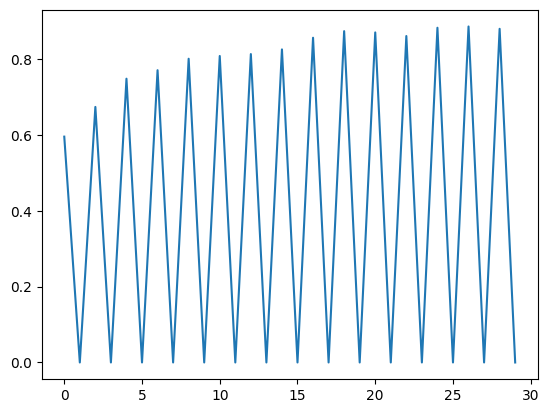

In [ ]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'],c='red') # Changed 'val_accuracy' to 'accuracy'
plt.title("acc vs val_acc")
plt.show()

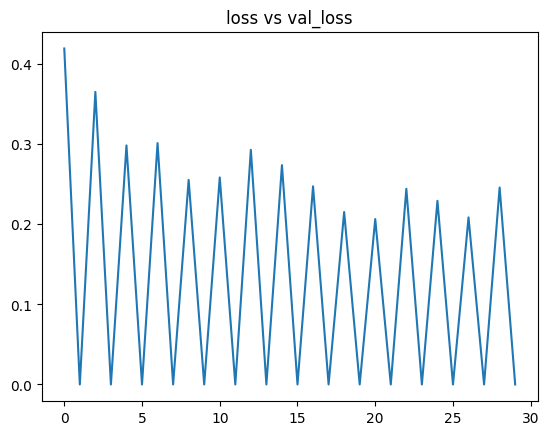

In [ ]:
plt.plot(h['loss'])

# Check if 'val_loss' exists in h before plotting
if 'val_loss' in h:
    plt.plot(h['val_loss'],c='red')
plt.title('loss vs val_loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted class: basal cell carcinoma (Probability: 1.0000)


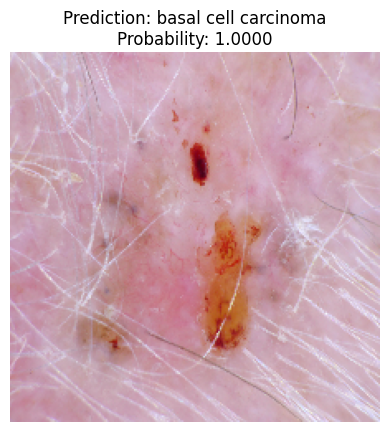

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess the image for prediction
path = "/content/train/basal cell carcinoma/ISIC_0024504.jpg"  # Ensure this path is correct
img = load_img(path, target_size=(224, 224))  # Resize the image to match the input shape

# Convert the image to an array and normalize it
input_arr = img_to_array(img) / 255.0  # Normalize the image (values between 0 and 1)
input_arr = np.expand_dims(input_arr, axis=0)  # Add batch dimension

# Predict the class probabilities
pred = model.predict(input_arr)
predicted_class = np.argmax(pred, axis=1)[0]  # Get the index of the highest probability

# Class labels (ensure these match the class order in your dataset)
class_labels = {
    0: 'keratosis',
    1: 'basal cell carcinoma',
    2: 'dermatofibroma',
    3: 'melanoma',
    4: 'nevus',
    5: 'pigmented benign keratosis',
    6: 'seborrheic keratosis',
    7: 'squamous cell carcinoma',
    8: 'vascular lesion'
}

# Print the prediction
predicted_label = class_labels[predicted_class]
predicted_prob = pred[0][predicted_class]
print(f"Predicted class: {predicted_label} (Probability: {predicted_prob:.4f})")

# Display the input image using matplotlib
plt.imshow(img)  # Display the original image
plt.title(f"Prediction: {predicted_label}\nProbability: {predicted_prob:.4f}")
plt.axis('off')  # Hide axis
plt.show()  # Display the image
